In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/LowRankVortex.jl/")

  Activating environment at `/media/mat/HDD/LowRankVortex.jl/Project.toml`


In [2]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [3]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [4]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-2.0, 2.0); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [5]:
Δtgif = 0.1

# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset, U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.0, 2.0, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

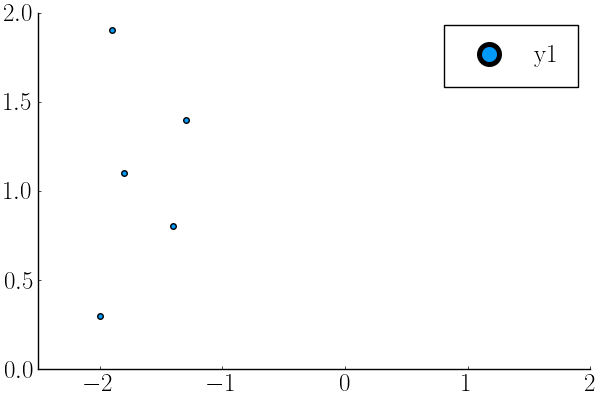

In [6]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [7]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = (blobs₊, blobs₋)

data = generate_vortex(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/LowRankVortex.jl/example2/data/");
tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/example2/data/data_test.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], 0.001, [-1.9296361617059616, 0.34217630309957153, 0.4555295410778555, -1.9202790210772893, 1.8921451593783287, 0.4955012656791485, -1.7932479872169391, 1.0692343859823297, 0.6042392412242923, -1.2515502710789115, 1.376341037698805, 0.5472607005875377, -1.4128184803392265, 0.8127105158895458, 0.5418824372646245], [-1.929562488988768 -1.927937115228725 … 12.757084936176026 12.758330412019905; 0.3422175649813723 0.34217154891574686 … 1.3846206667206227 1.384842291244625; … ; 0.8125670296765396 0.8128209907302766 … 0.763323101806398 0.7632850830053511; 0.5420412353658374 0.5417495806179543 … 0.5375606731159215 0.5377461028420395], [-0.5011426679764505 -0.520416571403946 … -0.49586243227042837 -0.5026571108592816; -0.5968734767287741 -0.5975960016066467 … -0.49931735443592096 -0.48804885799

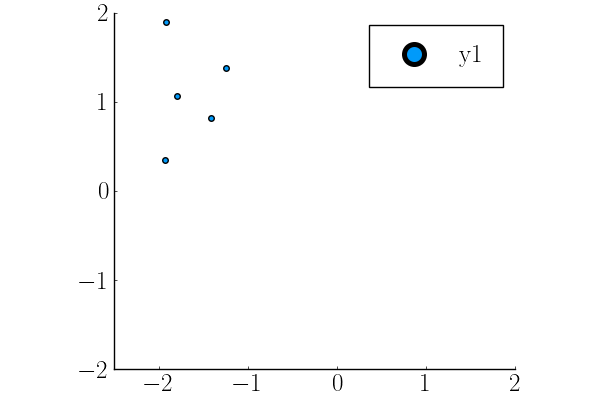

In [8]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

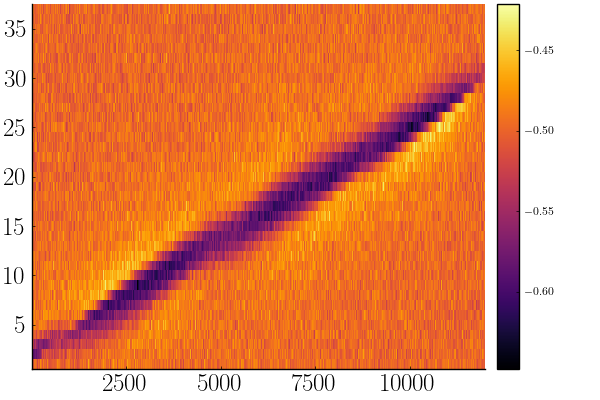

In [9]:
heatmap(data.yt)

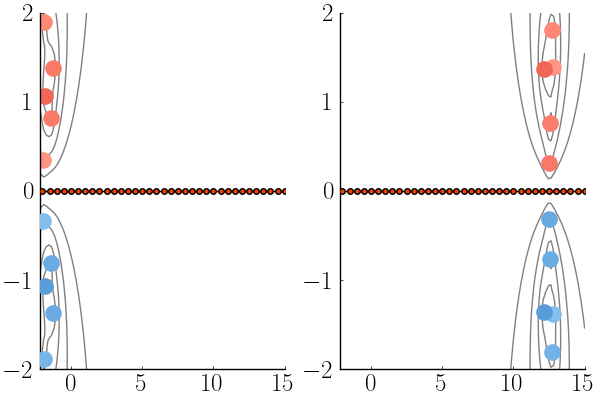

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [10]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

In [11]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config_data.Δt)+1
#     plt1 = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid; withvortices = true)
#     plt2 = plot(real(config_data.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config_data), xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), color = :teal, legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot(plt1, plt2)
# #     next!(prog)
# end

### Setup the sequential filter

In [12]:
config = deepcopy(config_data)

VortexConfig(5, 1.0 + 0.0im, ComplexF64[-2.0 + 0.0im, -1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im  …  11.5 + 0.0im, 12.0 + 0.0im, 12.5 + 0.0im, 13.0 + 0.0im, 13.5 + 0.0im, 14.0 + 0.0im, 14.5 + 0.0im, 15.0 + 0.0im, 15.5 + 0.0im, 16.0 + 0.0im], 0.001, 0.1, 0.0001, 0.0001, 1.0, 0.01)

In [13]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [14]:
enkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

Stochastic EnKF  with filtered = true


In [15]:
# save("ensemble_Ne_"*string(Ne)*".jld", "Xf", Xf, "Xa", Xa)

In [20]:
# Generate the initial condition

Ne = 50
Nx = 3*config.Nv
Ny = length(config.ss)

X0 = zeros(Ny+Nx, Ne)

zv = zeros(ComplexF64, Nv)

for k=1:Ne
    for i=1:Nclusters
        for j=1:Nset
    #         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
            zij = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 1, k] = real(zij)
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 2, k] = imag(zij)
        end
    end
end

Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]

for k = 1:Ne
    for i=1:Nclusters
        for j=1:Nset
            Γij = signclusters[i]*abs.((0.4 + 0.1*randn()))
#             Γij = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 3, k] = Γij
        end
    #         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
    end
end

In [ ]:
Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data; withfreestream  = true, P = serial)
# save("ensemble_Ne_"*string(Ne)*".jld", "Xf", Xf, "Xa", Xa)
rmse_enkf = mean(norm.(eachcol(mean_hist(Xa)-data.xt))[8000:end]/sqrt(size(data.x0,1)))

Progress:  32%|█████████████                            |  ETA: 0:00:55

In [19]:
Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
                                                  rxdefault = 10, rydefault = 8, P = serial)
rmse_lowrankenkf = mean(norm.(eachcol(mean_hist(Xalowrank)-data.xt))[8000:end]/sqrt(size(data.x0,1)))

Progress: 100%|█████████████████████████████████████████| Time: 0:04:02


0.06291244448722508